#Process for Making Prediction

A lot is written about how to tune specific time series forecasting models, but little help is given to how to use a model to make!! predictions.

Once you can build and tune forecast models for your data, the process of making a prediction involves the following steps:

    Model Selection. This is where we choose a model and gather evidences and support to defend the decision.
    Model Finalization. The chosen model is trained on all available data and saved to file for later use.
    Forecasting. The saved model is loaded and used to make a forecast.
    Model Update. Elements of the model are updated in the presence of new observations.

We will take a look at each of these elements in this tutorial, with a focus on saving and loading the model to and from file and using a loaded model to make predictions.

Before we dive in, let’s first look at a standard univariate dataset that we can use as the context for this tutorial.

# Daily Female Births Dataset

This dataset describes the number of daily female births in California in 1959.

The units are a count and there are 365 observations. The source of the dataset is credited to Newton (1988).

    Download the dataset.

Download the dataset and place it in your current working directory with the filename “daily-total-female-births.csv“.

We can load the dataset as a Pandas series. The snippet below loads and plots the dataset.

            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44


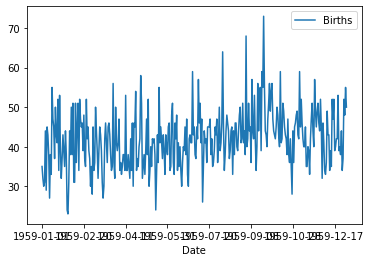

In [2]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
print(series.head())
series.plot()
pyplot.show()

# 1. Select Time Series Forecast Model

You must select a model.

This is where the bulk of the effort will be in preparing the data, performing analysis, and ultimately selecting a model and model hyperparameters that best capture the relationships in the data.

In this case, we can arbitrarily select an autoregression model (AR) with a lag of 6 on the differenced dataset.

We can demonstrate this model below.

First, the data is transformed by differencing, with each observation transformed as:
value(t) = obs(t) - obs(t - 1)
1
	
value(t) = obs(t) - obs(t - 1)

Next, the AR(6) model is trained on 66% of the historical data. The regression coefficients learned by the model are extracted and used to make predictions in a rolling manner across the test dataset.

As each time step in the test dataset is executed, the prediction is made using the coefficients and stored. The actual observation for the time step is then made available and stored to be used as a lag variable for future predictions.

Test RMSE: 7.259


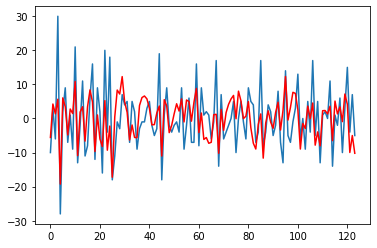

In [3]:
# fit and evaluate an AR model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt
 
# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)
 
# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat
 
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]
# train autoregression
window = 6
model = AutoReg(train, lags=6)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
    yhat = predict(coef, history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Running the example first prints the Root Mean Squared Error (RMSE) of the predictions, which is about 7 births on average.

This is how well we expect the model to perform on average when making forecasts on new data.
Test RMSE: 7.259
1
	
Test RMSE: 7.259

Finally, a graph is created showing the actual observations in the test dataset (blue) compared to the predictions (red).

This may not be the very best possible model we could develop on this problem, but it is reasonable and skillful.

# 2. Finalize and Save Time Series Forecast Model

Once the model is selected, we must finalize it.

This means save the salient information learned by the model so that we do not have to re-create it every time a prediction is needed.

This involves first training the model on all available data and then saving the model to file.

The statsmodels implementations of time series models do provide built-in capability to save and load models by calling save() and load() on the fit AutoRegResults object.

For example, the code below will train an AR(6) model on the entire Female Births dataset and save it using the built-in save() function, which will essentially pickle the AutoRegResults object.

The differenced training data must also be saved, both the for the lag variables needed to make a prediction, and for knowledge of the number of observations seen, required by the predict() function of the AutoRegResults object.

Finally, we need to be able to transform the differenced dataset back into the original form. To do this, we must keep track of the last actual observation. This is so that the predicted differenced value can be added to it.

In [4]:
# fit an AR model and save the whole model to file
from pandas import read_csv
from statsmodels.tsa.ar_model import AutoReg
import numpy
 
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)
 
# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = difference(series.values)
# fit model
model = AutoReg(X, lags=6)
model_fit = model.fit()
# save model to file
model_fit.save('ar_model.pkl')
# save the differenced dataset
numpy.save('ar_data.npy', X)
# save the last ob
numpy.save('ar_obs.npy', [series.values[-1]])

This code will create a file ar_model.pkl that you can load later and use to make predictions.

The entire training dataset is saved as ar_data.npy and the last observation is saved in the file ar_obs.npy as an array with one item.

The NumPy save() function is used to save the differenced training data and the observation. The load() function can then be used to load these arrays later.

The snippet below will load the model, differenced data, and last observation.

In [5]:
# load the AR model from file
from statsmodels.tsa.ar_model import AutoRegResults
import numpy
loaded = AutoRegResults.load('ar_model.pkl')
print(loaded.params)
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[50]


Running the example prints the coefficients and the last observation.

I think this is good for most cases, but is also pretty heavy. You are subject to changes to the statsmodels API.

My preference is to work with the coefficients of the model directly, as in the case above, evaluating the model using a rolling forecast.

In this case, you could simply store the model coefficients and later load them and make predictions.

The example below saves just the coefficients from the model, as well as the minimum differenced lag values required to make the next prediction and the last observation needed to transform the next prediction made.

In [12]:
# fit an AR model and manually save coefficients to file
from pandas import read_csv
from statsmodels.tsa.ar_model import AutoReg
import numpy
 
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)
 
# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = difference(series.values)
# fit model
window_size = 6
model = AutoReg(X, lags=window_size)
model_fit = model.fit()
# save coefficients
coef = model_fit.params
numpy.save('man_model.npy', coef)
# save lag
lag = X[-window_size:]
numpy.save('man_data.npy', lag)
# save the last ob
numpy.save('man_obs.npy', [series.values[-1]])

The coefficients are saved in the local file man_model.npy, the lag history is saved in the file man_data.npy, and the last observation is saved in the file man_obs.npy.

These values can then be loaded again as follows:

In [7]:
# load the manually saved model from file
import numpy
coef = numpy.load('man_model.npy')
print(coef)
lag = numpy.load('man_data.npy')
print(lag)
last_ob = numpy.load('man_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[-10   3  15  -4   7  -5]
[50]


Running this example prints the loaded data for review. We can see the coefficients and last observation match the output from the previous example.

Now that we know how to save a finalized model, we can use it to make forecasts.

# 3. Make a Time Series Forecast

Making a forecast involves loading the saved model and estimating the observation at the next time step.

If the AutoRegResults object was serialized, we can use the predict() function to predict the next time period.

The example below shows how the next time period can be predicted.

The model, training data, and last observation are loaded from file.

The period is specified to the predict() function as the next time index after the end of the training data set. This index may be stored directly in a file instead of storing the entire training data, which may be an efficiency.

The prediction is made, which is in the context of the differenced dataset. To turn the prediction back into the original units, it must be added to the last known observation.

In [8]:
# load AR model from file and make a one-step prediction
from statsmodels.tsa.ar_model import AutoRegResults
import numpy
# load model
model = AutoRegResults.load('ar_model.pkl')
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# make prediction
predictions = model.predict(start=len(data), end=len(data))
# transform prediction
yhat = predictions[0] + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


We can also use a similar trick to load the raw coefficients and make a manual prediction.
The complete example is listed below.

In [9]:
# load a coefficients and from file and make a manual prediction
import numpy
 
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat
 
# load model
coef = numpy.load('man_model.npy')
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
# make prediction
prediction = predict(coef, lag)
# transform prediction
yhat = prediction + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


Running the example, we achieve the same prediction as we would expect, given the underlying model and method for making the prediction are the same.

# 4. Update Forecast Model

Our work is not done.

Once the next real observation is made available, we must update the data associated with the model.

Specifically, we must update:

    The differenced training dataset used as inputs to make the subsequent prediction.
    The last observation, providing a context for the predicted differenced value.

Let’s assume the next actual observation in the series was 48.
The new observation must first be differenced with the last observation. It can then be stored in the list of differenced observations. Finally, the value can be stored as the last observation.

In the case of the stored AR model, we can update the ar_data.npy and ar_obs.npy files. The complete example is listed below:

In [10]:
# update the data for the AR model with a new obs
import numpy
# get real observation
observation = 48
# load the saved data
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# update and save differenced observation
diffed = observation - last_ob[0]
data = numpy.append(data, [diffed], axis=0)
numpy.save('ar_data.npy', data)
# update and save real observation
last_ob[0] = observation
numpy.save('ar_obs.npy', last_ob)

We can make the same changes for the data files for the manual case. Specifically, we can update the man_data.npy and man_obs.npy respectively.

The complete example is listed below.

In [11]:
# update the data for the manual model with a new obs
import numpy
# get real observation
observation = 48
# update and save differenced observation
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
diffed = observation - last_ob[0]
lag = numpy.append(lag[1:], [diffed], axis=0)
numpy.save('man_data.npy', lag)
# update and save real observation
last_ob[0] = observation
numpy.save('man_obs.npy', last_ob)

We have focused on one-step forecasts.

These methods would work just as easily for multi-step forecasts, by using the model repetitively and using forecasts of previous time steps as input lag values to predict observations for subsequent time steps.

Consider Storing All Observations

Generally, it is a good idea to keep track of all the observations.

This will allow you to:

    Provide a context for further time series analysis to understand new changes in the data.
    Train a new model in the future on the most recent data.
    Back-test new and different models to see if performance can be improved.

For small applications, perhaps you could store the raw observations in a file alongside your model.

It may also be desirable to store the model coefficients and required lag data and last observation in plain text for easy review.

For larger applications, perhaps a database system could be used to store the observations.

Summary

In this tutorial, you discovered how to finalize a time series model and use it to make predictions with Python.

Specifically, you learned:

    How to save a time series forecast model to file.
    How to load a saved time series forecast from file and make a prediction.
    How to update a time series forecast model with new observations.

Do you have any questions?
Ask your questions in the comments below and I will do my best to answer.